In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import cv2

In [2]:
training = np.load('training-images.npz')


In [3]:
testing =np.load('testing-images.npz')
x_test= testing['images']
y_test = testing['labels']

In [4]:
y_train = training['labels']
x_train = training['images']


In [5]:
print(y_train.dtype)
print(x_train.dtype)
print(x_train.shape)

int64
uint8
(5000, 32, 32, 3)


In [6]:
def binarize(image):
    # convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # create a binary thresholded image
    _, binary = cv2.threshold(gray, 110, 225, cv2.THRESH_BINARY_INV)
    return binary

# Image normalization

In [7]:
x_train[0].shape

(32, 32, 3)

In [8]:
x_train = x_train/255.0
x_test = x_test/255.0
#x_train[0]

In [9]:
#plt.imshow(x_train[54])
x_train[54].shape

(32, 32, 3)

# Model Building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "relu", input_shape = [32,32,3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

# Compiling model

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["sparse_categorical_accuracy"])

# Defining a Callback

In [12]:
ACCURACY_THRESHOLD = 0.99
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if (logs.get('sparse_categorical_accuracy')> ACCURACY_THRESHOLD ):
            print("\n Reached 99% accuracy, so cancelling training!")
            self.model.stop_training = True
            
            
callbacks = myCallback()

# Training the model


In [13]:
model.fit(x_train, y_train, epochs = 10, callbacks = [callbacks])

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.4767 - sparse_categorical_accuracy: 0.8466
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.1177 - sparse_categorical_accuracy: 0.9646
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0704 - sparse_categorical_accuracy: 0.9780
Epoch 4/10
5000/5000 [==============================] - 13s 3ms/sample - loss: 0.0449 - sparse_categorical_accuracy: 0.9868
Epoch 5/10
4992/5000 [============================>.] - ETA: 0s - loss: 0.0184 - sparse_categorical_accuracy: 0.9952
 Reached 99% accuracy, so cancelling training!
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0184 - sparse_categorical_accuracy: 0.9952


In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_loss, test_accuracy)

1000/1000 [==============================] - 1s 895us/sample - loss: 0.0634 - sparse_categorical_accuracy: 0.9760
0.06343979114165996 0.976


In [14]:
# As our model is trained now, lets get to our image

# Image preprocessing

In [15]:
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt

(514, 1181, 3)


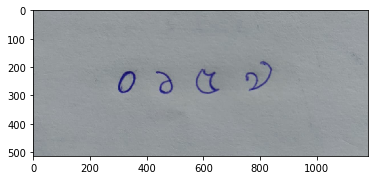

In [16]:
# read the image
image = cv2.imread("rgb.jpeg")
img = image.copy()
plt.imshow(image, cmap="gray")
print(img.shape)


In [17]:
def binarize(image):
    # convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # create a binary thresholded image
    _, binary = cv2.threshold(gray, 110, 225, cv2.THRESH_BINARY_INV)

    return binary

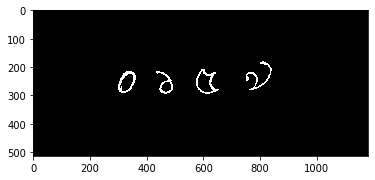

In [18]:
binary = binarize(image)
# show it
plt.imshow(binary, cmap="gray")
plt.imsave('bin.jpg',binary,cmap = "gray")

In [19]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(binary, contours, -1, (0, 255, 0), 2)

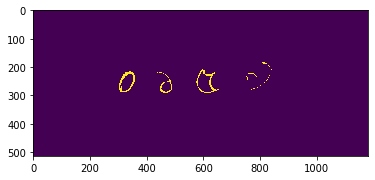

In [20]:
# show the image with the drawn contours
plt.imshow(image)
plt.show()

In [21]:
len(contours)

4

<h4> after drawing digit enclosing rectangles we use the binarised image to extract these smaller digit images  </h4>

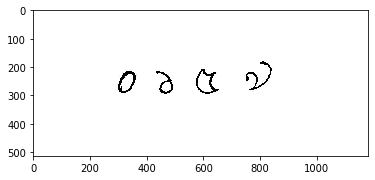

In [22]:

binr = cv2.imread('bin.jpg')
binr = cv2.bitwise_not(binr)
plt.imshow(binr)
#binr

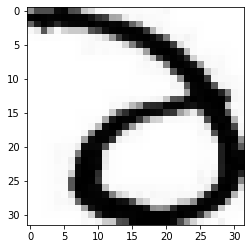

[1]


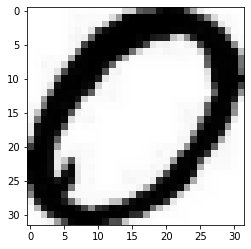

[0]


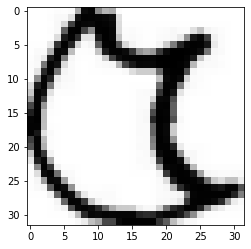

[5]


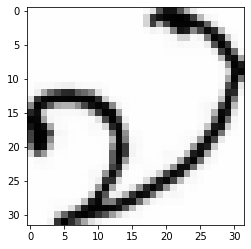

[9]


In [30]:
import numpy as np
ans = []
image_name = 0
x1,y1 = 0,0
segmented_image_updated = np.array([0])
for i in range(len(contours)):
    image_name += 1
    cnt = contours[i]
    x,y,w,h = cv2.boundingRect(cnt)
    segmented_image=binr[y:y+h,x:x+w]
    #plt.imshow(segmented_image)
    #plt.show()
    if abs(x1 - x) > 0.5 and abs(y-y1) > 0.5:
        if h >= 30 and w >= 30:
            segmented_image = resize(abs(segmented_image), (32,32))
            plt.imshow(segmented_image)
            plt.show()
            #cv2.imwrite(str(image_name) + '.jpg',segmented_image)
            
    x1,y1 = x,y
    
    segmented_image_updated = segmented_image
    
    op = model.predict_classes(tf.reshape(segmented_image,[1,32,32,3]))
    #num = np.where(op == np.amax(op))
    ans.append(op)
    print(op)

In [117]:
ans

[1, 0, 5, 9]